In [17]:
#Basandonos en el siguiente post: https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

# Feature Selection
### A partir de distintos algoritmos buscaremos seleccionar los features que mas informacion aportan a la prediccion del target

## Preprocesamiento

In [18]:
import Utilidades as ut
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_classif



#En realidad habria que levantar un set de datos que no este destinado a redes neuronales, un 'feature_selection.pkl'

#Cargamos el dataset
df = pd.read_pickle("Archivos/Feature_Selection_entrenamiento.pkl")
df_test = pd.read_pickle("Archivos/Feature_Selection_validacion.pkl")

#Dividimos el dataframe en features-labels
df_x, df_y = ut.split_labels(df)
df_x_test, df_y_test = ut.split_labels(df_test)

#Procesamos los dataframes
df_x, df_x_test = ut.conversion_fechas(df_x, df_x_test)
df_x, df_x_test = ut.codificar_categoricas(df_x, df_y, df_x_test, modo='catboost')
df_x, df_x_test = ut.normalizacion_numericas(df_x, df_x_test, modo='normalizacion')

#Convertimos el dataframe a un array de numpy
x = ut.df_a_vector(df_x)
y = ut.df_a_vector(df_y).flatten()

/home/julian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Information Gain

In [19]:
importances = mutual_info_classif(x, y)
feat_importances = pd.Series(importances, df_x.columns[0:len(df.columns)])

<AxesSubplot:>

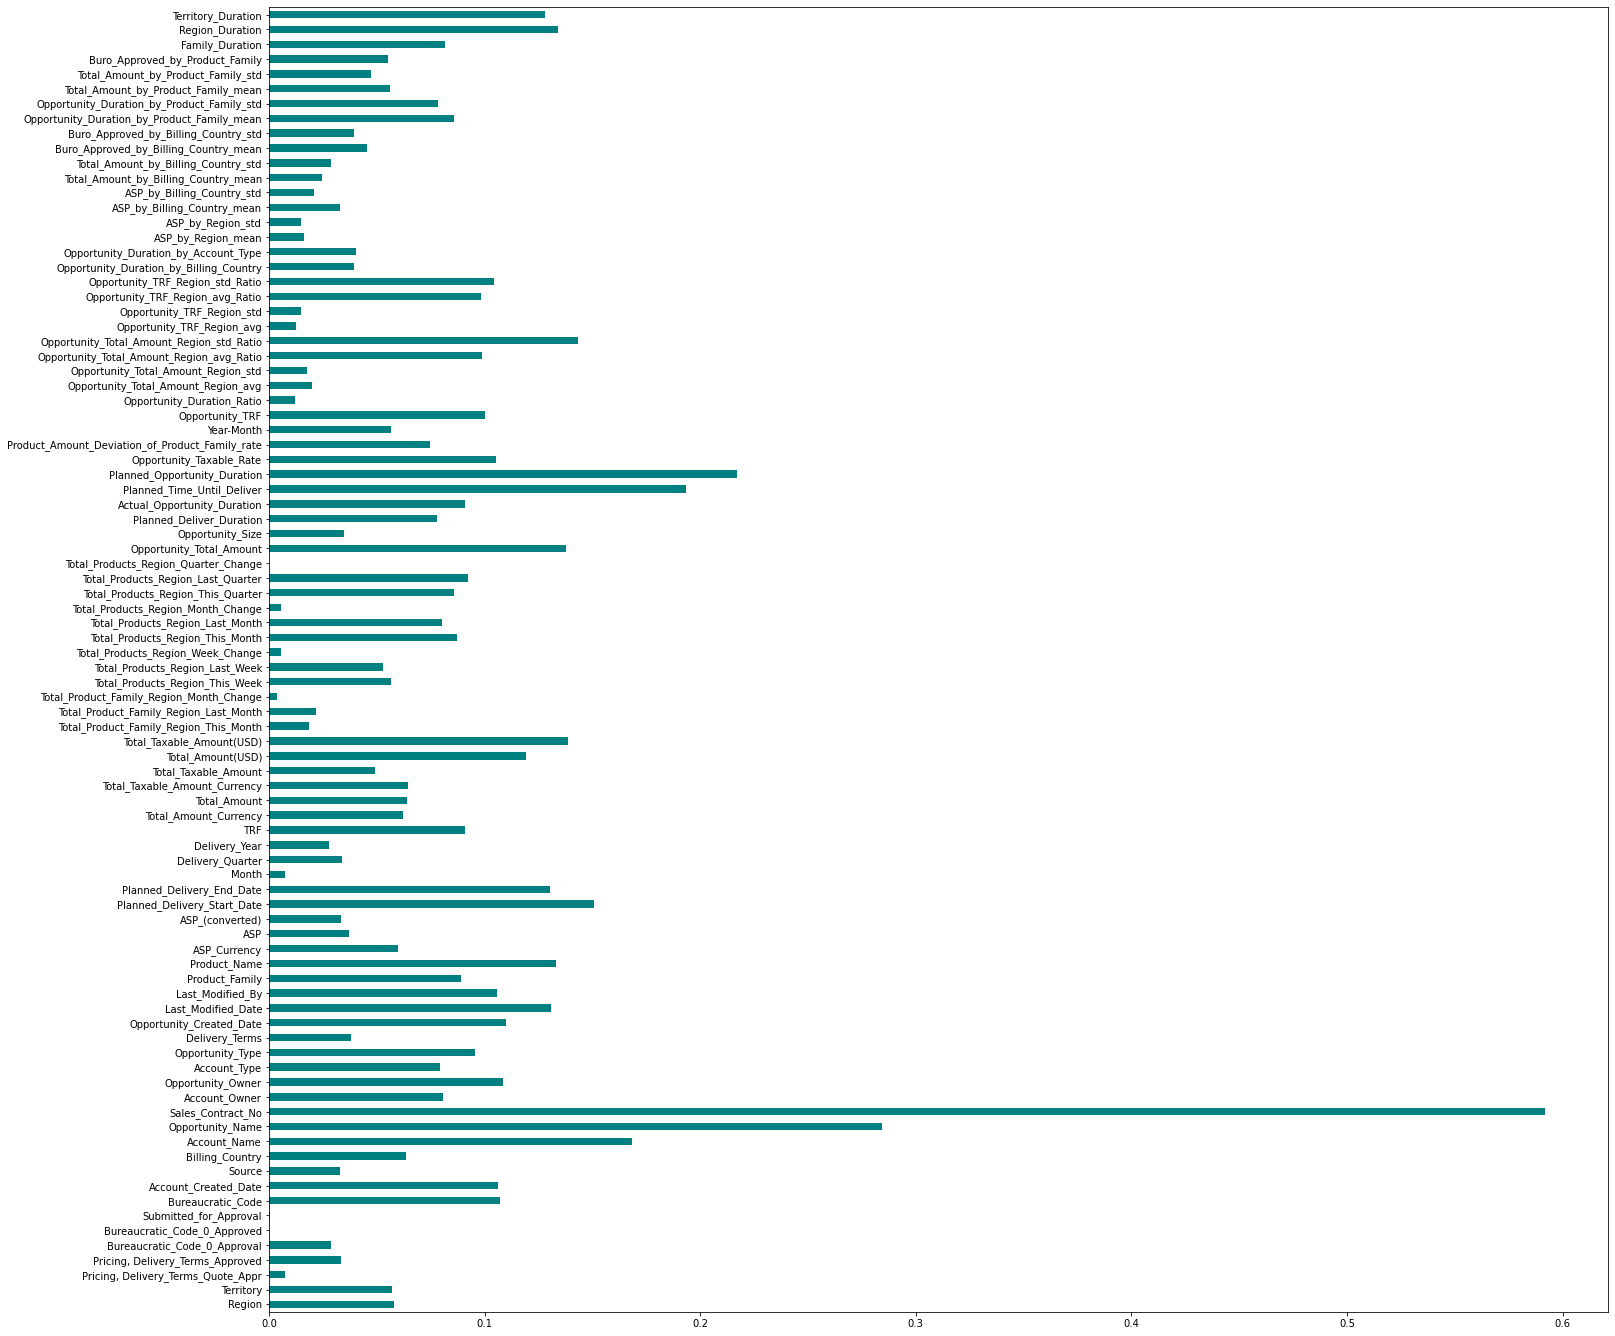

In [20]:
feat_importances.plot(kind='barh', color='teal', figsize=(24, 24))

In [21]:
features = feat_importances.to_frame()
features.columns = ['Score']
features = features.sort_values('Score', ascending=False).reset_index()
features['idx'] = features.index
features['Score'] = (features.shape[0] - features.idx) / 10
features = features.drop(columns=['idx']).set_index('index')
features

,Score
index,
Sales_Contract_No,8.8
Opportunity_Name,8.7
Planned_Opportunity_Duration,8.6
Planned_Time_Until_Deliver,8.5
Account_Name,8.4
...,...
Total_Products_Region_Week_Change,0.5
Total_Product_Family_Region_Month_Change,0.4
Submitted_for_Approval,0.3


## Fisher's Score

<AxesSubplot:>

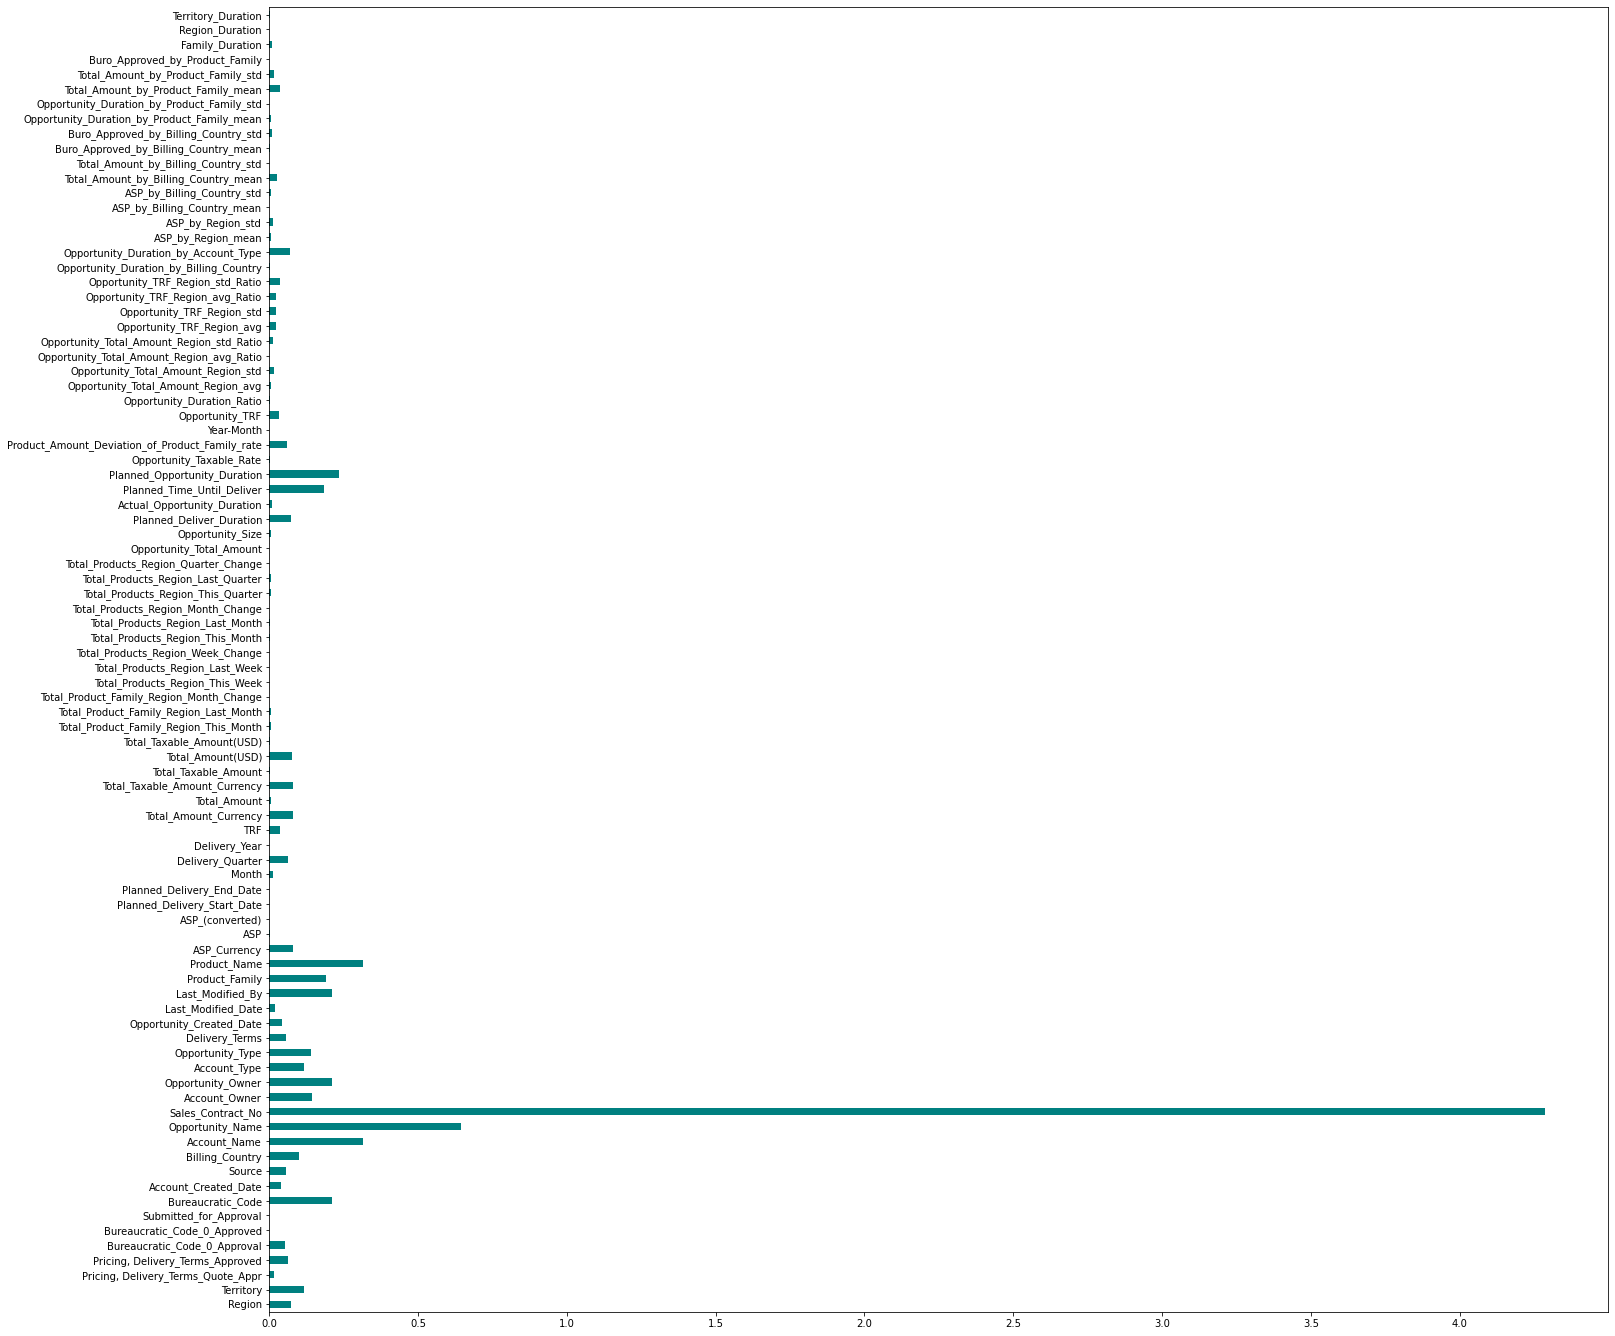

In [22]:
from skfeature.function.similarity_based import fisher_score

ranks = fisher_score.fisher_score(x, y)
feat_importances = pd.Series(ranks, df_x.columns[0:len(df.columns)])
feat_importances.plot(kind='barh', color='teal', figsize=(24, 24))

In [23]:
actual = feat_importances.to_frame()
actual.columns = ['Score']
actual = actual.sort_values('Score', ascending=False).reset_index()
actual['idx'] = actual.index
actual['Score'] = (actual.shape[0] - actual.idx) / 10
actual = actual.drop(columns=['idx']).set_index('index')

features['Score'] = features['Score'] + actual['Score']
features

,Score
index,
Sales_Contract_No,17.6
Opportunity_Name,17.4
Planned_Opportunity_Duration,17.0
Planned_Time_Until_Deliver,16.4
Account_Name,16.9
...,...
Total_Products_Region_Week_Change,1.4
Total_Product_Family_Region_Month_Change,1.1
Submitted_for_Approval,0.4


## Correlation Coefficient

In [24]:
import seaborn as sns

#Damos un punto extra por cada threshold

thresholds = [0.1, 0.2, 0.3, 0.4]

combined = df_x.copy()
combined['Stage'] = df_y['Stage']

cor = combined.corr()
#plt.figure(figsize = (24, 24))
#sns.heatmap(cor, annot=True)
cor = cor.drop(index=['Stage'])[['Stage']]

for t in thresholds:
    index = cor[np.abs(cor.Stage) > t].index
    features.loc[index, ['Score']] = features.loc[index, ['Score']] + 1

## Variance Threshold

In [25]:
from sklearn.feature_selection import VarianceThreshold

#Con threshold elegimos el valor de la varianza a partir de la cual queremos marcar a las columnas como "varianza cero"
v_t = VarianceThreshold(threshold=0)
#Procesamos con el dataset de train
v_t.fit(x)
#Obtenemos una serie de pandas donde cada fila indica si el feature tiene (True) o no tiene (False) varianza superior al threshold
result = pd.Series(v_t.get_support())
result.index = features['Score'].index
features['Score'] = features['Score'] + result

In [26]:
features.nlargest(30, columns='Score')

,Score
index,
Sales_Contract_No,22.6
Opportunity_Name,22.4
Planned_Opportunity_Duration,22.0
Account_Name,21.9
Product_Name,21.4
Planned_Time_Until_Deliver,20.4
Opportunity_Owner,20.4
Last_Modified_By,20.2
Bureaucratic_Code,20.2


In [27]:
features.nlargest(30, columns='Score').index

Index(['Sales_Contract_No', 'Opportunity_Name', 'Planned_Opportunity_Duration',
       'Account_Name', 'Product_Name', 'Planned_Time_Until_Deliver',
       'Opportunity_Owner', 'Last_Modified_By', 'Bureaucratic_Code',
       'Product_Family', 'Opportunity_Type', 'Total_Amount(USD)',
       'Account_Owner', 'Account_Type', 'Opportunity_Created_Date',
       'Billing_Country', 'Territory', 'Account_Created_Date',
       'Planned_Deliver_Duration', 'Total_Taxable_Amount_Currency',
       'Last_Modified_Date', 'Total_Amount_Currency', 'ASP_Currency',
       'Opportunity_TRF_Region_std_Ratio',
       'Product_Amount_Deviation_of_Product_Family_rate', 'Opportunity_TRF',
       'Region', 'Opportunity_Total_Amount_Region_std_Ratio', 'TRF',
       'Opportunity_TRF_Region_avg_Ratio'],
      dtype='object', name='index')

In [36]:
features.nlargest(20, columns='Score').index

Index(['Sales_Contract_No', 'Opportunity_Name', 'Planned_Opportunity_Duration',
       'Account_Name', 'Product_Name', 'Planned_Time_Until_Deliver',
       'Opportunity_Owner', 'Last_Modified_By', 'Bureaucratic_Code',
       'Product_Family', 'Opportunity_Type', 'Total_Amount(USD)',
       'Account_Owner', 'Account_Type', 'Opportunity_Created_Date',
       'Billing_Country', 'Territory', 'Account_Created_Date',
       'Planned_Deliver_Duration', 'Total_Taxable_Amount_Currency'],
      dtype='object', name='index')

In [29]:
features.nlargest(10, columns='Score').index

Index(['Sales_Contract_No', 'Opportunity_Name', 'Planned_Opportunity_Duration',
       'Account_Name', 'Product_Name', 'Planned_Time_Until_Deliver',
       'Opportunity_Owner', 'Last_Modified_By', 'Bureaucratic_Code',
       'Product_Family'],
      dtype='object', name='index')